<a href="https://colab.research.google.com/github/EllouziMedAmin/Data-Science/blob/main/sentiment_OHE1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip /content/tweet-sentiment-extraction.zip

Archive:  /content/tweet-sentiment-extraction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
!rm /content/tweet-sentiment-extraction.zip

In [31]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import seaborn as sns

In [65]:
twiiter_file='train.csv'
test='test.csv'
df=pd.read_csv(twiiter_file)
test_df=pd.read_csv(test)

In [66]:
df.shape,test_df.shape

((27481, 4), (3534, 3))

In [67]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [68]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [69]:
df.info(),test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


(None, None)

In [70]:
df.isnull().sum(),test_df.isnull().sum()

(textID           0
 text             1
 selected_text    1
 sentiment        0
 dtype: int64,
 textID       0
 text         0
 sentiment    0
 dtype: int64)

In [71]:
df=df.dropna()

In [72]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [73]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


In [74]:
cat_id={
    'neutral':1,
    'positive':2,
    'negative':0
}


In [75]:
df['class']=df['sentiment'].map(cat_id)
test_df['class']=test_df['sentiment'].map(cat_id)

In [78]:
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


In [79]:
test_df.head()

,textID,text,sentiment,class
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,0
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,2


In [80]:
#hyperparametre
BATCH_SIZE = 512
NUM_EPOCH=80

In [85]:
from re import X
#separate independent and dependent features
X_train=df['text'].values
y_train=df['class'].values

In [86]:
X_valid=test_df['text'].values
y_valid=test_df['class'].values


In [87]:
X_valid.shape,y_valid.shape

((3534,), (3534,))

In [47]:
#X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=123)

In [88]:
X_train.shape,y_train.shape

((27480,), (27480,))

In [89]:
X_valid.shape,y_valid.shape

((3534,), (3534,))

In [90]:
one_hot=CountVectorizer()
X_train_one_hot=one_hot.fit_transform(X_train)
X_valid_one_hot=one_hot.transform(X_valid)


In [91]:
#Dataset class
class SentimentData(Dataset):
  def __init__(self,X,y):
    super().__init__()
    self.X=torch.Tensor(X.toarray())
    self.y=torch.Tensor(y).type(torch.LongTensor)

  def __len__(self):
    return len(self.X)

  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

In [92]:
train_ds=SentimentData(X_train_one_hot,y_train)
valid_ds=SentimentData(X_valid_one_hot,y_valid)

In [93]:
#dataloader
train_loader=DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=DataLoader(valid_ds,batch_size=15000,shuffle=True)

In [94]:
#model
class SentimentModel(nn.Module):
  def __init__(self,NUM_FEATURES,NUM_CLASSES, HIDDEN=10):
    super().__init__()
    self.linear=nn.Linear(NUM_FEATURES,HIDDEN)
    self.linear2=nn.Linear(HIDDEN,NUM_CLASSES)
    self.relu=nn.ReLU()
    self.log_softmax=nn.LogSoftmax(dim=1)

  def forward(self,x):
    x=self.linear(x)
    x=self.relu(x)
    x=self.linear2(x)
    x=self.log_softmax(x)
    return x

In [95]:
#model , loss and optimizer
model=SentimentModel(NUM_FEATURES=X_train_one_hot.shape[1],NUM_CLASSES=3)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(model.parameters())

In [103]:
#training

training_losses= []
for e in range(100):
  current_loss=0
  for x_batch,y_batch in train_loader:
    optimizer.zero_grad()
    y_pred_log=model(x_batch)
    loss=criterion(y_pred_log,y_batch.long())
    current_loss+=loss.item()
    loss.backward()
    optimizer.step()
  training_losses.append(current_loss)
  print(f"epoch {e} loss {current_loss}")

epoch 0 loss 3.534871868789196
epoch 1 loss 3.501390017569065
epoch 2 loss 3.4597254060208797
epoch 3 loss 3.411303583532572
epoch 4 loss 3.3755491450428963
epoch 5 loss 3.347141321748495
epoch 6 loss 3.3047814927995205
epoch 7 loss 3.26926352083683
epoch 8 loss 3.2432215809822083
epoch 9 loss 3.1907174214720726
epoch 10 loss 3.158217430114746
epoch 11 loss 3.108002357184887
epoch 12 loss 3.091983735561371
epoch 13 loss 3.054772011935711
epoch 14 loss 3.033730175346136
epoch 15 loss 2.9988350309431553
epoch 16 loss 2.955437660217285
epoch 17 loss 2.924936331808567
epoch 18 loss 2.8913505896925926
epoch 19 loss 2.8679638020694256
epoch 20 loss 2.8395682461559772
epoch 21 loss 2.8016690239310265
epoch 22 loss 2.773878701031208
epoch 23 loss 2.7654840257018805
epoch 24 loss 2.7305053807795048
epoch 25 loss 2.6998027861118317
epoch 26 loss 2.660411350429058
epoch 27 loss 2.649768179282546
epoch 28 loss 2.6142692863941193
epoch 29 loss 2.5954569578170776
epoch 30 loss 2.5771469715982676
epo

<Axes: >

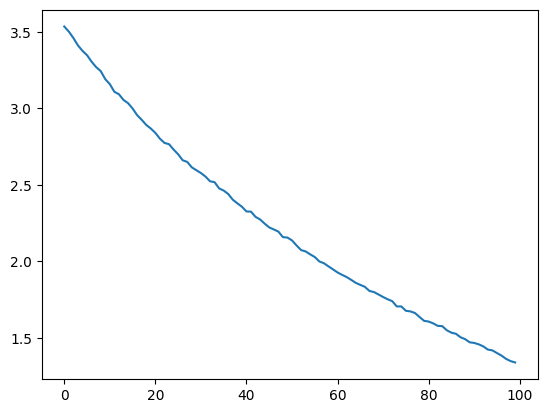

In [104]:
sns.lineplot(x=list(range(len(training_losses))),y=training_losses)

In [105]:
with torch.no_grad():
  for x_batch,y_batch in valid_loader:
    y_valid_pred_log=model(x_batch)
    y_valid_pred=torch.argmax(y_valid_pred_log,dim=1)


In [106]:
y_valid_pred_np=y_valid_pred.squeeze().cpu().numpy()

In [107]:
accuray=accuracy_score(y_pred=y_valid_pred_np,y_true=y_valid)
f"The accuracy of the model is {np.round(accuray,3)*100}%"

'The accuracy of the model is 33.7%'

In [108]:
most_common_cnt=Counter(y_valid).most_common()[0][1]
f"Naive classifier : {np.round(most_common_cnt/len(y_valid)*100,1)}%"

'Naive classifier : 40.5%'

<Axes: >

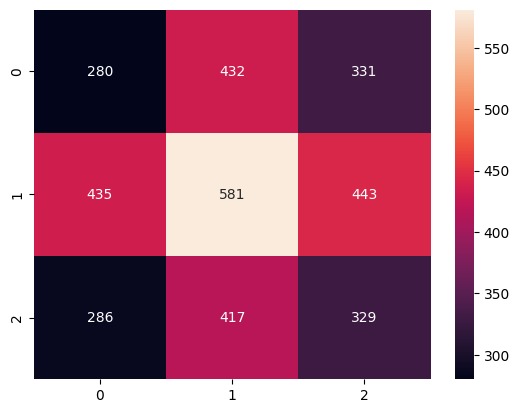

In [109]:
sns.heatmap(confusion_matrix(y_valid_pred_np,y_valid),annot=True,fmt=".0f")